In [88]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pickle
from pyitlib import discrete_random_variable as drv

In [20]:
BENCHMARKS = {
     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

In [21]:
def get_all_files(root_folder='../run/results/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                all_files.append(os.path.join(root, file))

    return all_files


def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def sort_by_mean(df, asc=True):
    df = df.reindex(df.transpose().mean().sort_values(ascending=asc).index)
    df = df.reindex(df.mean().sort_values(ascending=asc).index, axis=1)
    return df


def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_clean_df(preds_to_drop=None):
    files = get_all_files()
    print(files[0])
    df = make_df(files)
    return df

Note: there are many other useful methods in NASLib/plotting/PlotCorrelations.ipynb

Note: to compute the mutual information and/or entropy of a random variable (a zero-cost proxy)
if we only have samples of that random variable (e.g. 500 samples, or 15625 samples): we need to discretize the random variable. That is, make a set of bins with equal number of ZC proxy values in each bin. For example, make 10 or 100 bins, based on how many samples we have.

If we want to compute the conditional entropy conditioned on two ZC proxies, we need to create 5x5=25 bins (or 10x10=100, etc), since we need to discretize both.

In [22]:
def discretize(values, bins=10):
    bin_edges = np.histogram_bin_edges(values, bins=bins)
    bin_edges[-1] += 1
    return np.digitize(values, bin_edges)



In [23]:
def cond_ent_k_predictors(df, predictors):
    ent_arr = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
        df_ = df[(df['seed'] == seed)]
        preds = []
        for predictor in predictors:
            preds.append(np.array(df_[df_['predictor'] == predictor]['preds'].to_list()[0]))

        truths = np.array(df_[df_['predictor'] == predictors[0]]['ground_truth'].to_list()[0])
        n_bins = int(np.round(1+3.322*np.log(len(preds[0]))))

        preds_disc = []
        for pred in preds:
            preds_disc.append(discretize(pred, bins=n_bins))

        truths_disc = discretize(truths, bins=n_bins)

        all_joint_ent = drv.entropy_joint(np.vstack([preds_disc, truths_disc]))
        preds_ent = drv.entropy_joint(preds_disc)
        cond_ent = all_joint_ent - preds_ent
        ent_arr.append(cond_ent)
    
    
    return np.array(ent_arr).mean()
    

In [24]:
def cond_ent_single_predictor(df, predictor):
    ent_arr = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
        df_ = df[(df['seed'] == seed)]
        preds = np.array(df_[df_['predictor'] == predictor]['preds'].to_list()[0])
        truths = np.array(df_[df_['predictor'] == predictor]['ground_truth'].to_list()[0])
        n_bins = int(np.round(1+3.322*np.log(len(preds))))

        preds_disc = discretize(preds, bins=n_bins) 
        truths_disc = discretize(truths, bins=n_bins)

        #mutual_info = drv.information_mutual(preds_disc, truths_disc)
        cond_ent = drv.entropy_conditional(truths_disc, preds_disc)
        ent_arr.append(cond_ent)
    
    return np.array(ent_arr).mean()


In [25]:
def select_best_predictor(df, final_list, candidate_list):

    if len(final_list) == 0:
        score_list = [cond_ent_single_predictor(df_, candidate) for candidate in candidate_list]

    else:
        score_list = [cond_ent_k_predictors(df_, final_list + [candidate]) for candidate in candidate_list]
    
    score_dict = dict(zip(candidate_list, score_list))
    best_predictor = sorted(score_dict.items(), key=lambda kv:kv[1])[0][0]
    final_list.append(best_predictor)
    candidate_list.remove(best_predictor)

    return final_list, candidate_list


In [26]:
df = make_clean_df()
df_ = df[(df['search_space'] == 'nasbench201') & (df['dataset'] == 'cifar100')]


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json
1.5167352954363769
0.40890776308905463


In [28]:
import itertools
#find k best ZC proxies minimizing conditional entropy 
def find_k_predictors(df, k, predictors, mode='maximum'):
    assert mode in ['maximum', 'greedy', 'random']
    assert k <= len(predictors)
        
    if mode == 'random':
        return np.random.choice(predictors, size=k, replace=False)
    elif mode == 'maximum':
        #compute all combinations of k predictors, choose largest
        min_ent = np.inf
        best_k = None
        for comb in itertools.combinations(predictors, k):
            score = cond_ent_k_predictors(df, np.array(comb))
            if score < min_ent:
                min_ent = score
                best_k = comb
        return np.array(best_k)
    else:
        #iteratively add to the list
        final_k = []
        candidate_list = predictors.tolist()
        while len(final_k) < k:
            final_k, candidate_list = select_best_predictor(df, final_k, candidate_list)
        return np.array(final_k)  
        
    

In [29]:
print(df_['predictor'].unique())

['fisher' 'grad_norm' 'plain' 'snip' 'synflow' 'zen' 'nwot' 'flops'
 'jacov' 'params' 'grasp' 'epe_nas' 'l2_norm']


In [39]:
for k in range(1,3):
    print(find_k_predictors( df_, k, df_['predictor'].unique(), 'greedy' ))

['synflow']
['synflow' 'plain']


# Get lists of proxies

In [60]:
def get_proxy_lists(df):
    
    greedy_proxy_list = []
    for k in range(1,13):
        lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'greedy' )
        greedy_proxy_list.append(lst)

    maximize_proxy_list = []
    for k in range(1,13):
        lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'maximum' )
        maximize_proxy_list.append(lst)
    

    random_proxy_list = []
    for k in range(1,13):
        lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'random' )
        random_proxy_list.append(lst)

    return greedy_proxy_list, maximize_proxy_list, random_proxy_list

In [ ]:
proxy_list_dict = {}
for bench in BENCHMARKS:
    print(bench)
    proxy_list_dict[bench] = {}
    for dataset in BENCHMARKS[bench]:
        proxy_list_dict[bench][dataset] = {}
        print(dataset)
        df_specific = df[(df['search_space'] == bench) & (df['dataset'] == dataset)]
        greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
        proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
        proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
        proxy_list_dict[bench][dataset]['random'] = random_lst


        

nasbench101
cifar10
nasbench201
cifar10
cifar100
ImageNet16-120
nasbench301
cifar10
transbench101_micro
jigsaw
class_scene
class_object
autoencoder
normal
room_layout
segmentsemantic


In [81]:
proxy_list_dict['transbench101_macro']['normal']

{'greedy': [array(['synflow'], dtype='<U7'),
  array(['synflow', 'plain'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm'],
        dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher', 'jacov'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher', 'jacov', 'epe_nas'], dtype='<U9'),
  array(['synflow', 'plain', '

In [82]:
bench = 'transbench101_macro'
dataset = 'room_layout'
df_specific = df[(df['search_space'] == 'transbench101_macro') & (df['dataset'] == dataset)]
greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
proxy_list_dict[bench][dataset] = {}
proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
proxy_list_dict[bench][dataset]['random'] = random_lst

In [83]:
bench = 'transbench101_macro'
dataset = 'segmentsemantic'
df_specific = df[(df['search_space'] == 'transbench101_macro') & (df['dataset'] == dataset)]
greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
proxy_list_dict[bench][dataset] = {}
proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
proxy_list_dict[bench][dataset]['random'] = random_lst

In [85]:
proxy_list_dict['transbench101_macro']['room_layout']

{'greedy': [array(['synflow'], dtype='<U7'),
  array(['synflow', 'plain'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip'], dtype='<U7'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm'],
        dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher', 'jacov'], dtype='<U9'),
  array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
         'nwot', 'zen', 'fisher', 'jacov', 'epe_nas'], dtype='<U9'),
  array(['synflow', 'plain', '

In [87]:
proxy_list_dict

{'nasbench101': {'cifar10': {'greedy': [array(['synflow'], dtype='<U7'),
    array(['synflow', 'plain'], dtype='<U7'),
    array(['synflow', 'plain', 'l2_norm'], dtype='<U7'),
    array(['synflow', 'plain', 'l2_norm', 'flops'], dtype='<U7'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip'], dtype='<U7'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm'],
          dtype='<U9'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
           'nwot'], dtype='<U9'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
           'nwot', 'zen'], dtype='<U9'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
           'nwot', 'zen', 'fisher'], dtype='<U9'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
           'nwot', 'zen', 'fisher', 'jacov'], dtype='<U9'),
    array(['synflow', 'plain', 'l2_norm', 'flops', 'snip', 'grad_norm',
           'nwot', 'zen', 'fisher', 'jaco

In [89]:
with open('proxy_list.pkl', 'wb') as f:
    pickle.dump(proxy_list_dict, f)

In [91]:
with open('proxy_list.pkl', 'rb') as f:
    pl = pickle.load(f)

# Plot entropy vs num proxies

In [34]:
proxy_list = []
for k in range(1,13):
    lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'greedy' )
    print(lst)
    proxy_list.append(lst)

['synflow']
['synflow' 'plain']
['synflow' 'plain' 'l2_norm']
['synflow' 'plain' 'l2_norm' 'flops']
['synflow' 'plain' 'l2_norm' 'flops' 'snip']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot' 'zen']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot' 'zen'
 'fisher']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot' 'zen'
 'fisher' 'jacov']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot' 'zen'
 'fisher' 'jacov' 'epe_nas']
['synflow' 'plain' 'l2_norm' 'flops' 'snip' 'grad_norm' 'nwot' 'zen'
 'fisher' 'jacov' 'epe_nas' 'params']


In [35]:
random_proxy_list = []
for _ in range(100):
    proxy_list = []
    for k in range(1,13):
        lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'random' )
        proxy_list.append(lst)
    random_proxy_list.append(proxy_list)

In [38]:
entropy_trials = np.array([calculate_entropy_from_proxy_list(df_, proxy_list) for proxy_list in random_proxy_list])


In [39]:
greedy_proxy_list = []
for k in range(1,13):
    lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'greedy' )
    greedy_proxy_list.append(lst)

greedy_ent = calculate_entropy_from_proxy_list(df_, greedy_proxy_list)


In [40]:
maximize_proxy_list = []
for k in range(1,13):
    lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'maximum' )
    maximize_proxy_list.append(lst)

maximize_ent = calculate_entropy_from_proxy_list(df_, maximize_proxy_list)


In [37]:
def calculate_entropy_from_proxy_list(df, predictor_lists):
    entropy_list = []
    for item in predictor_lists:
        if len(item) == 1:
            entropy = cond_ent_single_predictor(df, item[0])
        else:
            entropy = cond_ent_k_predictors(df, item)
        entropy_list.append(entropy)
    return np.array(entropy_list)
    

In [50]:
def plot(arr1, arr2, arr3, title, xlabel, ylabel, figsize=(6, 4)):
    x = arr1
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_mean, label='random')
    plt.fill_between(range(len(x_mean)), x_mean-x_std, x_mean+x_std, alpha=0.6)
    
    plt.plot(arr2, label='greedy')
    plt.plot(arr3, label='maximize')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0,3)
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(len(x_mean)), np.arange(1, len(x_mean)+1))




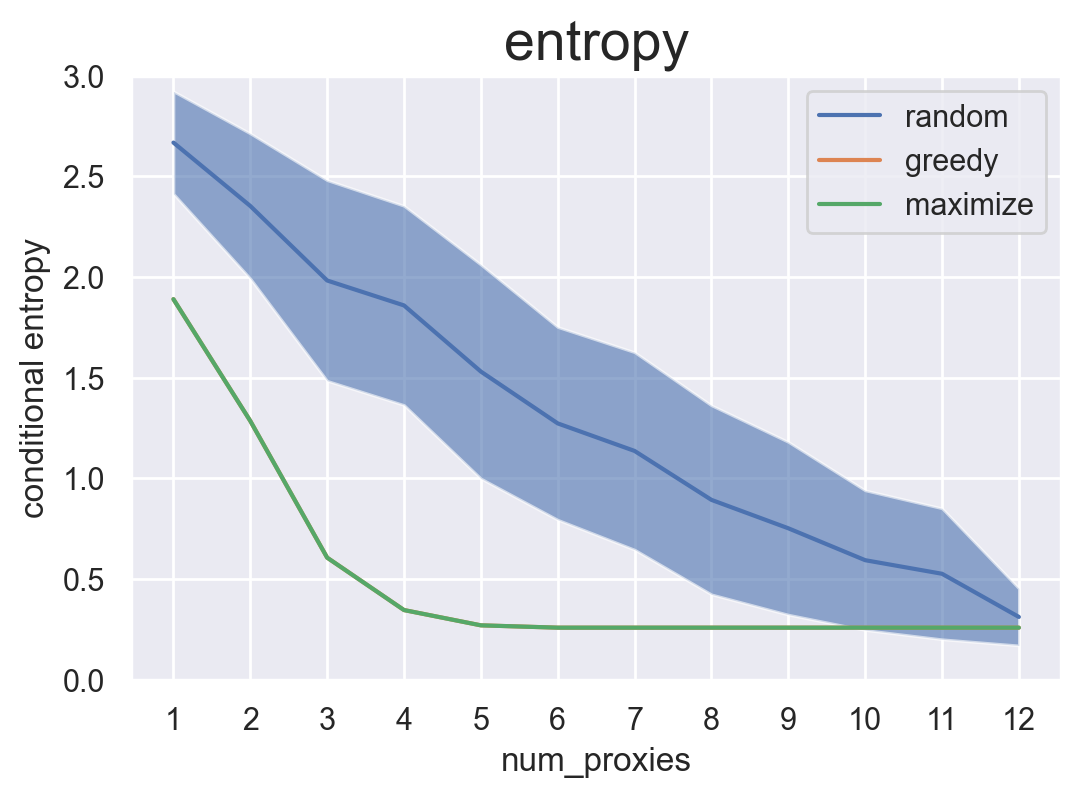

In [51]:
plot(entropy_trials, greedy_ent, maximize_ent, 'entropy', 'num_proxies', 'conditional entropy')